### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

from tcn import TCN
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import gc

In [2]:
df_test = pd.read_csv("test_dataset.csv", parse_dates=["Date"])
df_test = df_test.sort_values("Date").reset_index(drop=True)

df_train = pd.read_csv("train_dataset.csv", parse_dates=["Date"])
df_train.drop(columns=['Next_Close', 'Next_3_Close', 'Next_7_Close'], inplace=True)
df_test.drop(columns=['Next_Close', 'Next_3_Close', 'Next_7_Close'], inplace=True)

df_test = df_test.iloc[:-10]

In [3]:
df_test.shape

(388, 53)

In [4]:
# Function to clear TensorFlow memory before running any model so that the model doesnt predict on cached data
def clear_tf_memory():
    K.clear_session()
    gc.collect()

### Testing ARIMA Model



Rolling Forecast ARIMA TEST (t+1) with order (1, 1, 1)
ARIMA Test (t+1): R² = 0.8655, RMSE = 228.79, MAE = 170.45


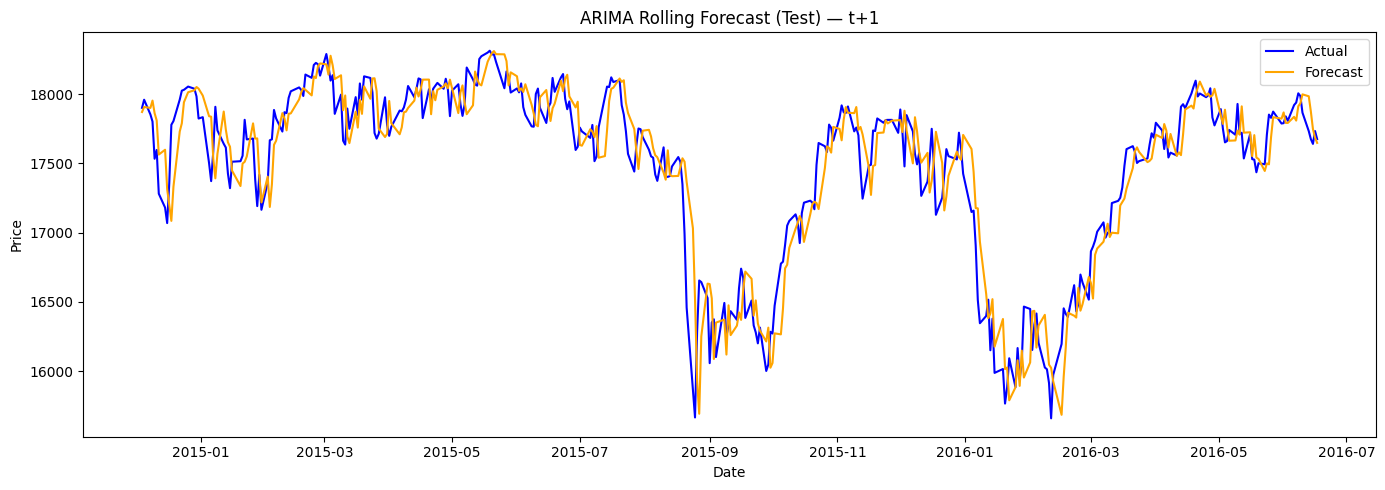


Rolling Forecast ARIMA TEST (t+3) with order (1, 1, 1)
ARIMA Test (t+3): R² = 0.7433, RMSE = 316.38, MAE = 236.20


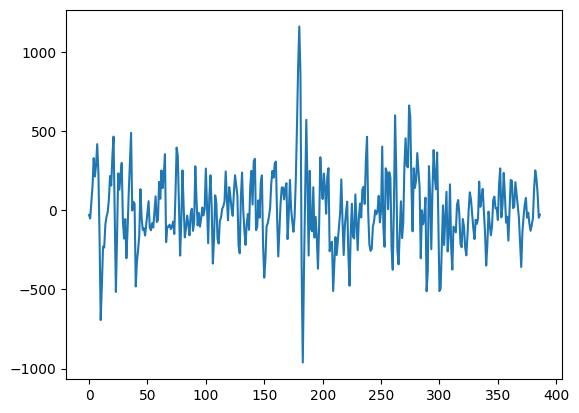

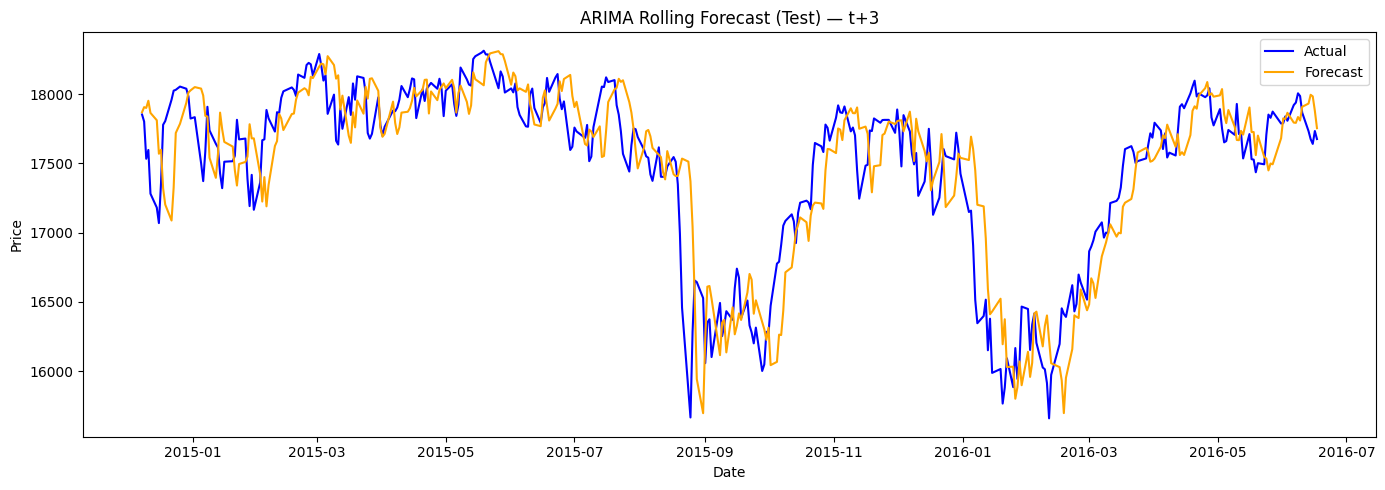


Rolling Forecast ARIMA TEST (t+7) with order (1, 1, 1)
ARIMA Test (t+7): R² = 0.5662, RMSE = 413.11, MAE = 317.17


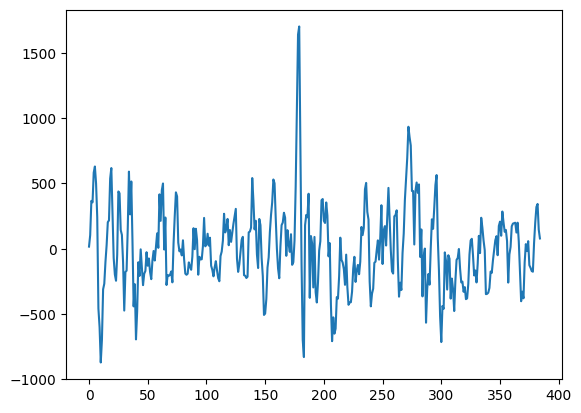

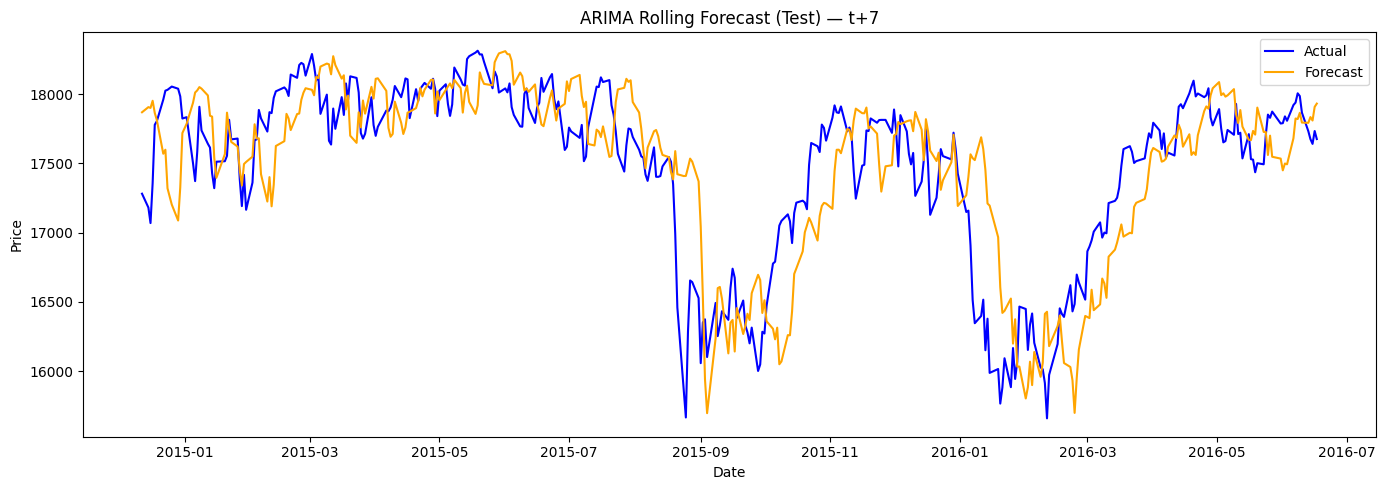

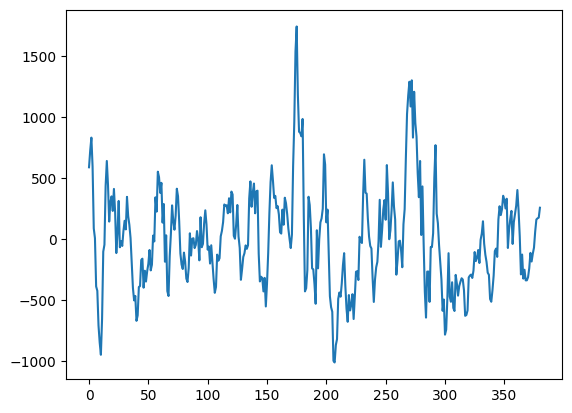

In [5]:
def arima_true_rolling_test(df_train, df_test, forecast_horizon=1, order=(1, 1, 1)):
    print(f"\nRolling Forecast ARIMA TEST (t+{forecast_horizon}) with order {order}")

    close_series = df_train['Close'].tolist() + df_test['Close'].tolist()
    start_idx = len(df_train)
    history = close_series[:start_idx]  # Only train data initially

    y_true = []
    y_pred = []

    for t in range(len(df_test) - forecast_horizon):
        try:
            model = ARIMA(history, order=order).fit()
            forecast = model.forecast(steps=forecast_horizon)
            y_pred.append(forecast[-1])
            y_true.append(close_series[start_idx + t + forecast_horizon])
        except:
            y_pred.append(np.nan)
            y_true.append(np.nan)

        history.append(close_series[start_idx + t])  # simulate real-time update

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    date_series = df_test['Date'].iloc[forecast_horizon: len(y_true) + forecast_horizon].values

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"ARIMA Test (t+{forecast_horizon}): R² = {r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

    plt.figure(figsize=(14, 5))
    plt.plot(date_series, y_true, label='Actual', color='blue')
    plt.plot(date_series, y_pred, label='Forecast', color='orange')
    plt.title(f"ARIMA Rolling Forecast (Test) — t+{forecast_horizon}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/arima_test_t_plus_{forecast_horizon}.png")
    plt.show()

    plt.plot(np.array(y_pred) - np.array(y_true), label='Prediction Error (t+h - forecast)')

    return {"horizon": forecast_horizon, "R2": r2, "RMSE": rmse, "MAE": mae}

test_results = []
for horizon in [1, 3, 7]:
    clear_tf_memory()
    res = arima_true_rolling_test(df_train, df_test, forecast_horizon=horizon, order=(1, 1, 1))
    test_results.append(res)

### Testing LSTM Model

In [6]:
df_lstm = df_test.drop(columns=['Date', 'Label', 'Target']).copy()


🔍 Testing lstm_tplus1_simple


b:\DCU\Practicum\Proj\App\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test R²: 0.7606, RMSE: 319.58, MAE: 263.98


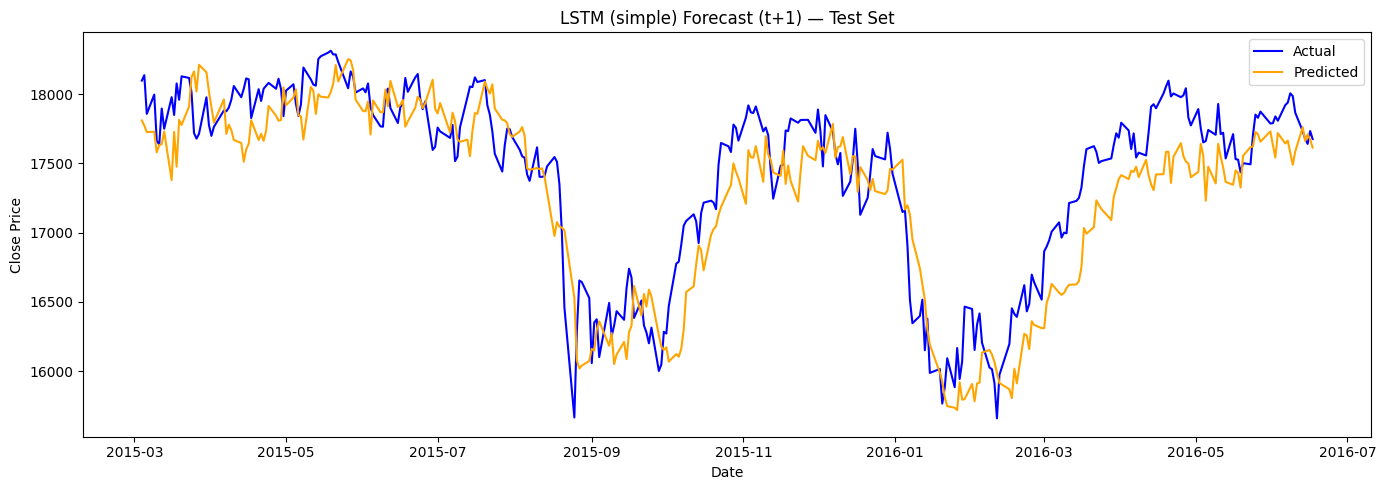

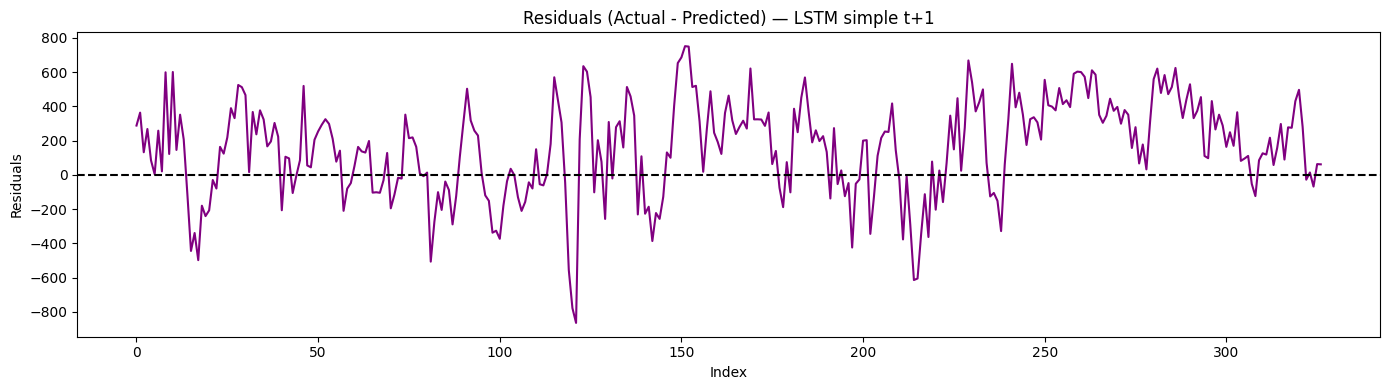


🔍 Testing lstm_tplus3_simple


b:\DCU\Practicum\Proj\App\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test R²: 0.2669, RMSE: 559.01, MAE: 459.02


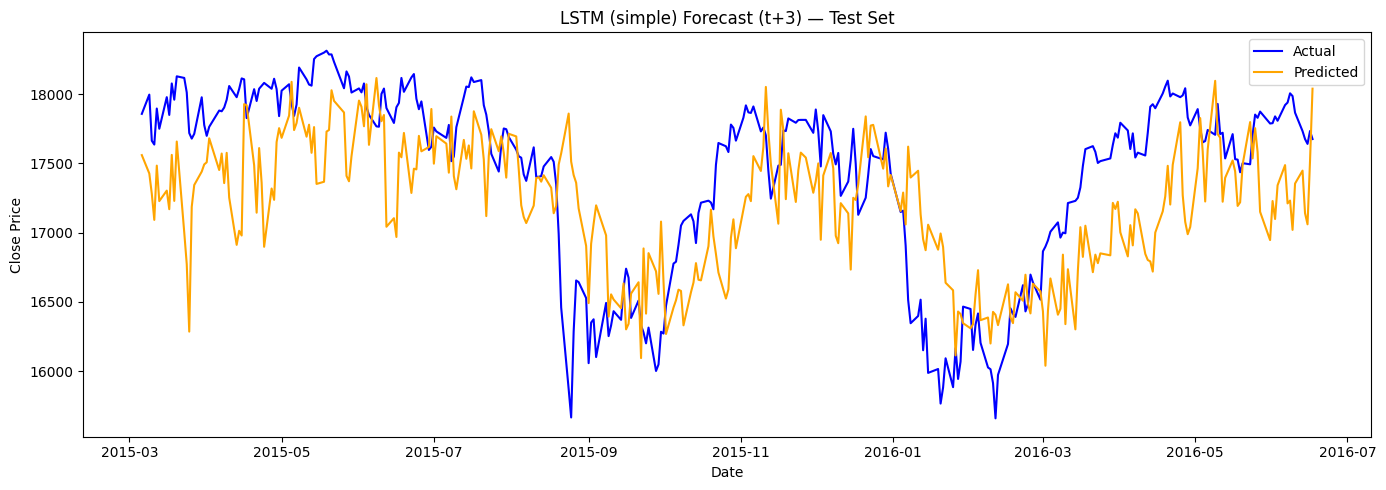

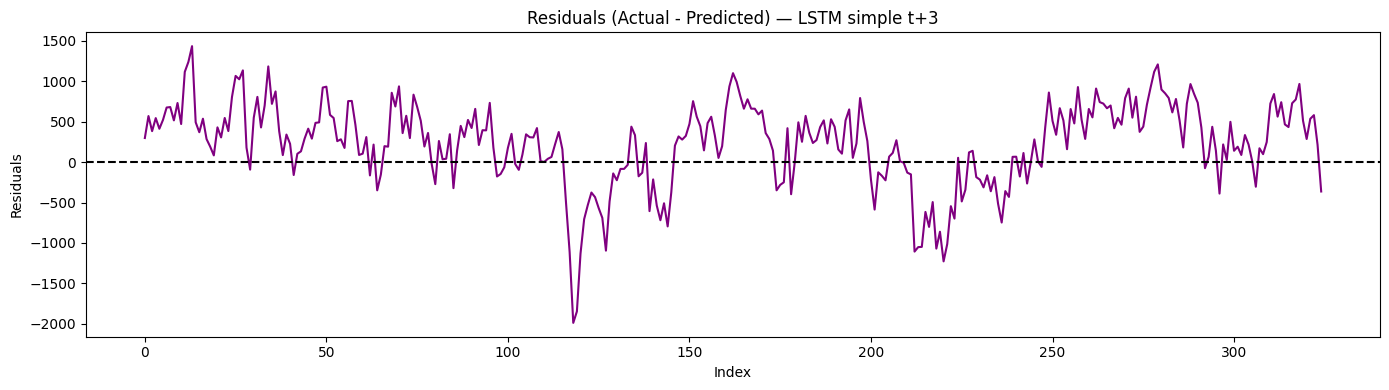


🔍 Testing lstm_tplus7_simple


b:\DCU\Practicum\Proj\App\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test R²: 0.4156, RMSE: 501.07, MAE: 384.07


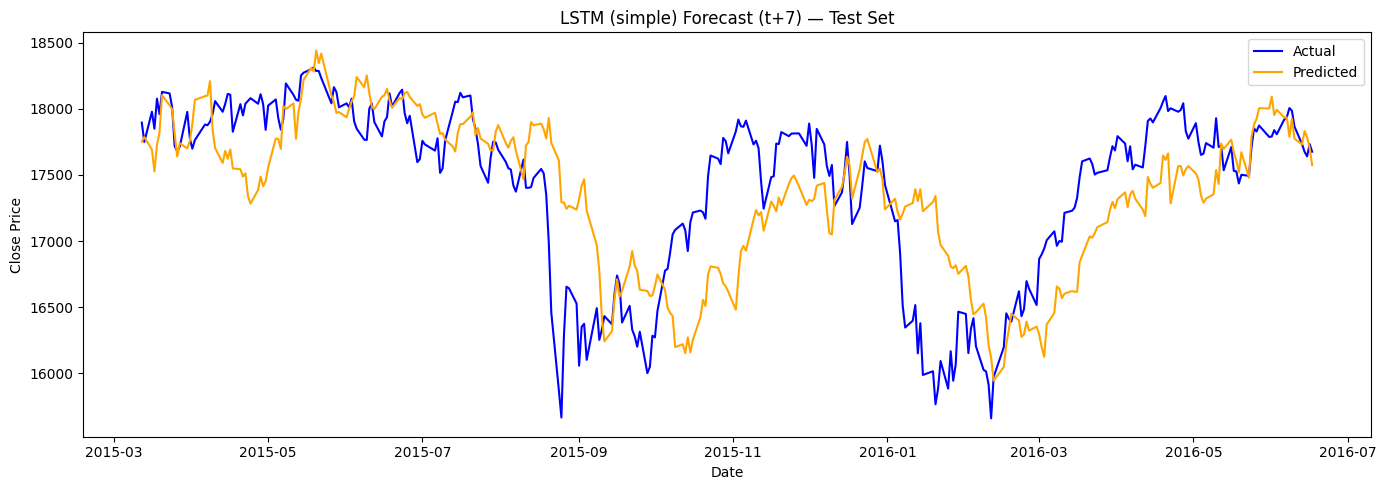

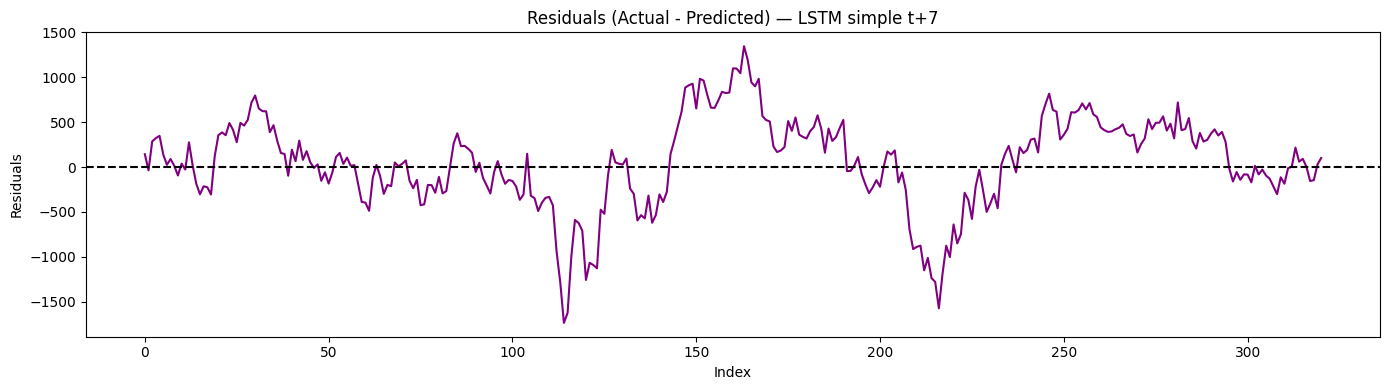


🔍 Testing lstm_tplus1_stacked


b:\DCU\Practicum\Proj\App\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Test R²: 0.3267, RMSE: 535.94, MAE: 454.12


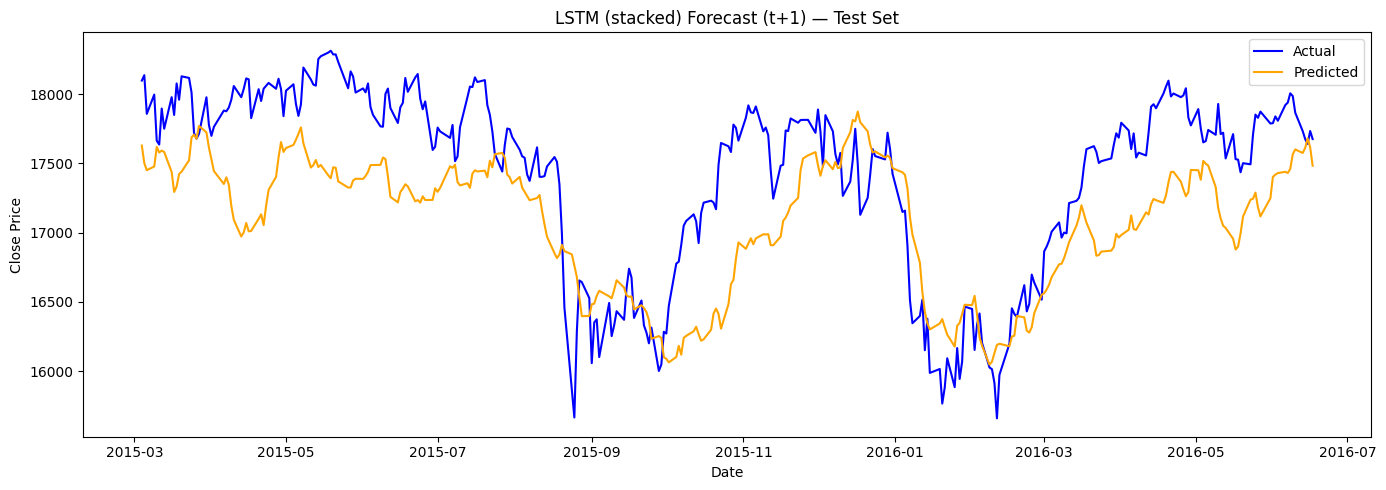

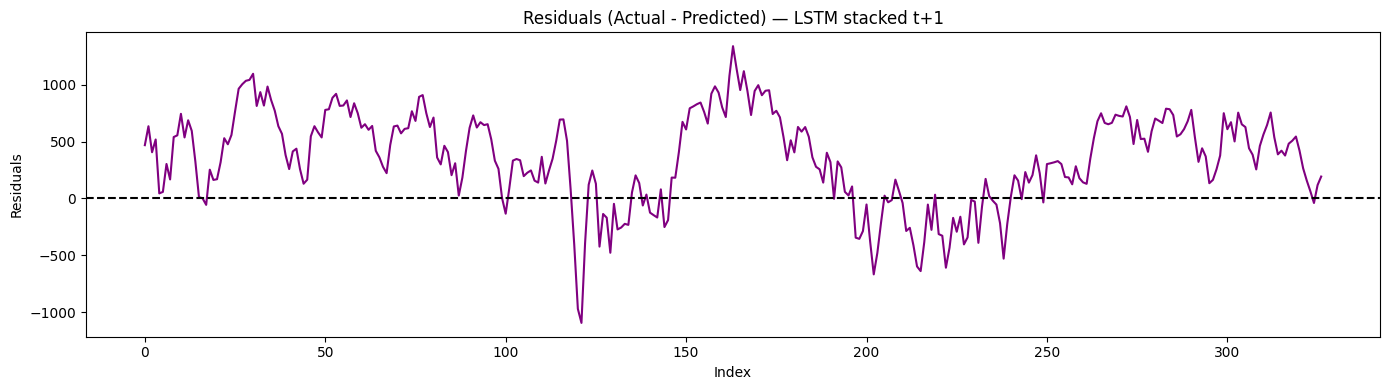


🔍 Testing lstm_tplus3_stacked


b:\DCU\Practicum\Proj\App\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Test R²: 0.3985, RMSE: 506.37, MAE: 409.86


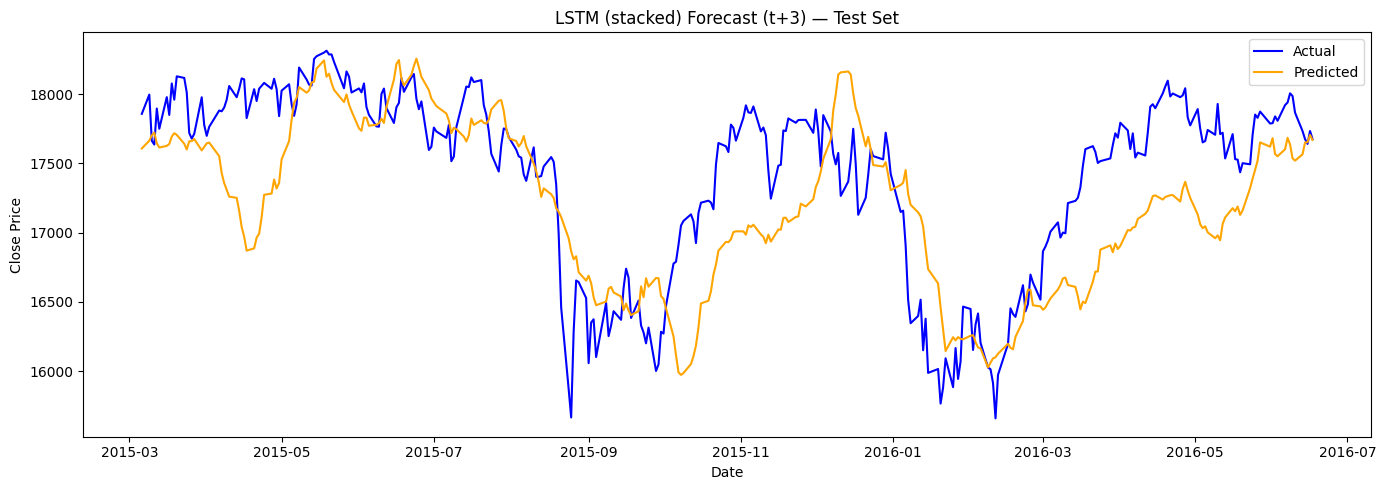

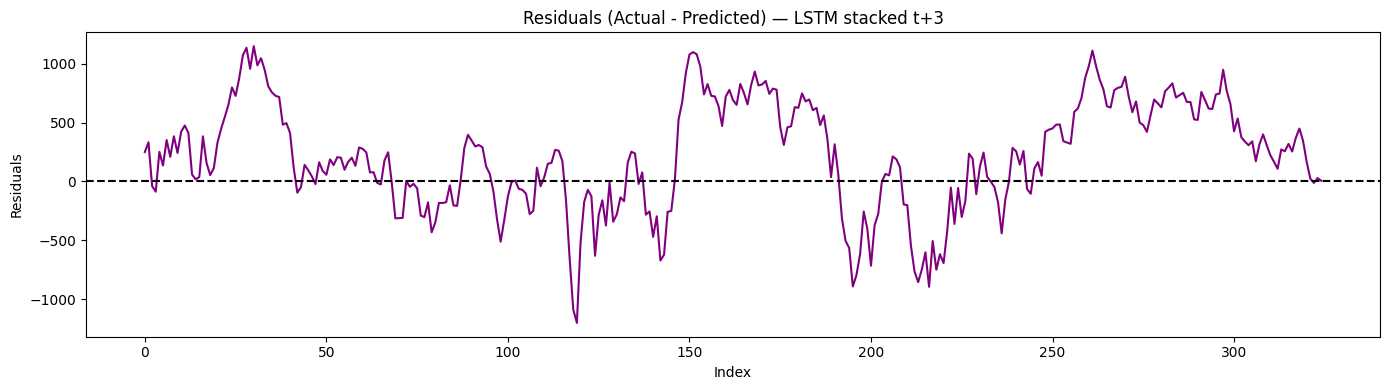


🔍 Testing lstm_tplus7_stacked


b:\DCU\Practicum\Proj\App\venv_3_11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Test R²: 0.4252, RMSE: 496.95, MAE: 376.23


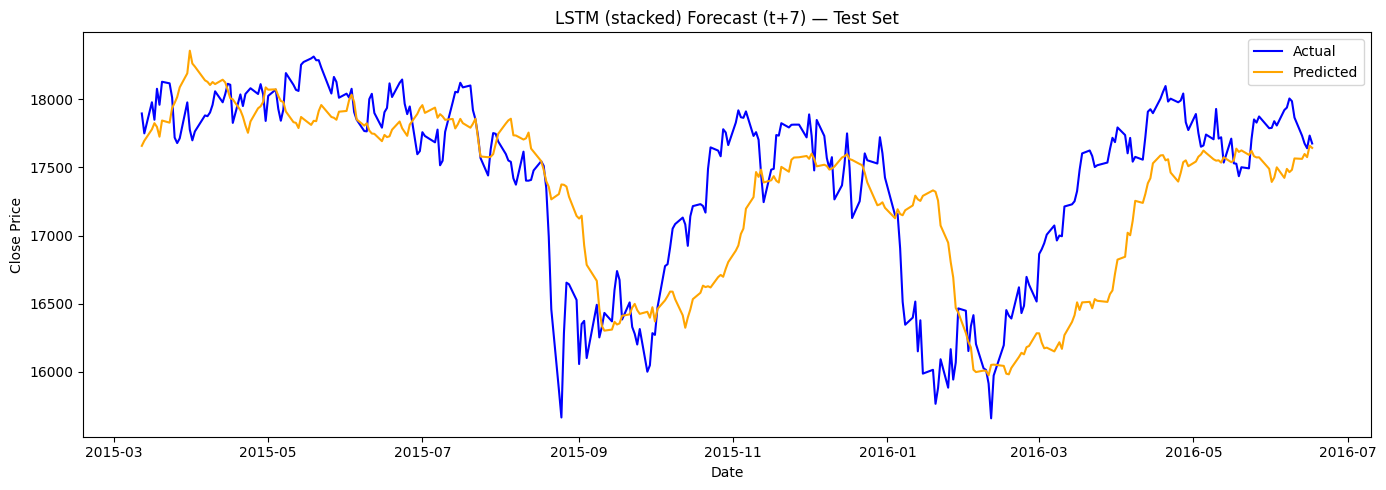

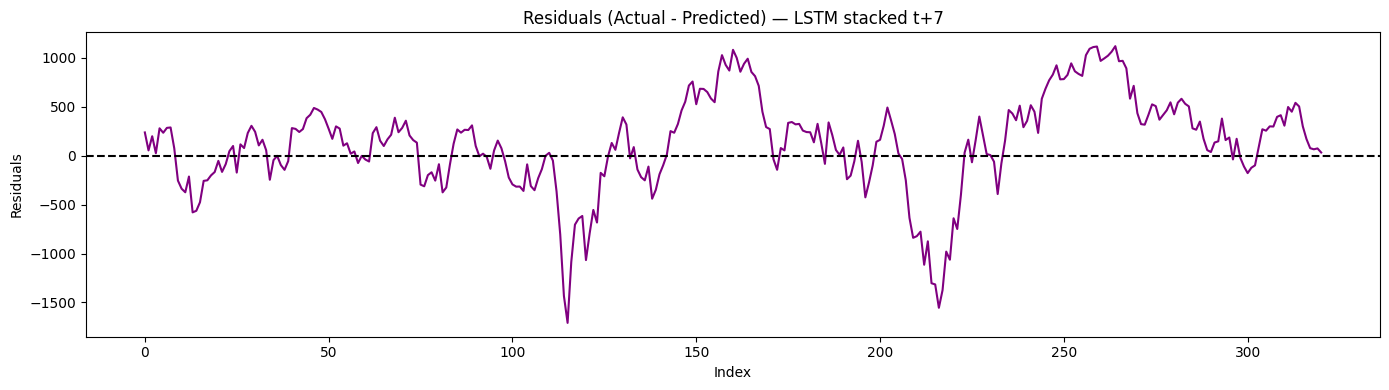

In [ ]:
def load_and_test_lstm_fixed(model_dir, model_type='simple', forecast_horizon=1, df_lstm=None, window_size=60):

    assert model_type in ['simple', 'stacked'], "model_type must be 'simple' or 'stacked'"
    model_name = f"lstm_tplus{forecast_horizon}_{model_type}"

    model_path = os.path.join(model_dir, f"{model_name}.keras")
    scalerX_path = os.path.join(model_dir, f"{model_name}_scalerX.pkl")
    scalerY_path = os.path.join(model_dir, f"{model_name}_scalerY.pkl")
    feature_path = os.path.join(model_dir, f"{model_name}_features.pkl")

    if not all(os.path.exists(p) for p in [model_path, scalerX_path, scalerY_path]):
        print(f"Missing files for {model_name}")
        return None

    print(f"\n🔍 Testing {model_name}")

    # Load model and scalers
    model = load_model(model_path)
    X_scaler = joblib.load(scalerX_path)
    y_scaler = joblib.load(scalerY_path)

    # column order
    if os.path.exists(feature_path):
        feature_columns = joblib.load(feature_path)
        df_lstm = df_lstm[feature_columns]
    else:
        print("Feature list not found — assuming current df_lstm column order is correct.")

    close_series = df_lstm['Close'].values

    # Scale X
    X_scaled = X_scaler.transform(df_lstm)

    # Create test sequences
    X_seq = []
    for i in range(window_size, len(X_scaled) - forecast_horizon):
        X_seq.append(X_scaled[i - window_size:i])
    X_seq = np.array(X_seq)

    # Predict
    y_pred_scaled = model.predict(X_seq)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    # Build true y directly from original Close
    y_true = close_series[window_size + forecast_horizon : window_size + forecast_horizon + len(y_pred)]

    date_series = df_test['Date'].iloc[window_size + forecast_horizon : window_size + forecast_horizon + len(y_pred)]

    # Evaluate
    r2 = r2_score(y_true, y_pred.flatten())
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"Test R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Plot predictions
    plt.figure(figsize=(14, 5))
    plt.plot(date_series, y_true, label='Actual', color='blue')
    plt.plot(date_series, y_pred.flatten(), label='Predicted', color='orange')
    plt.title(f"LSTM ({model_type}) Forecast (t+{forecast_horizon}) — Test Set")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/lstm_test_t_plus_{forecast_horizon}_{model_type}.png")
    plt.show()

    # Plot residuals
    residuals = y_true - y_pred.flatten()
    plt.figure(figsize=(14, 4))
    plt.plot(residuals, color='purple')
    plt.axhline(0, linestyle='--', color='black')
    plt.title(f"Residuals (Actual - Predicted) — LSTM {model_type} t+{forecast_horizon}")
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/lstm_residuals_t_plus_{forecast_horizon}_{model_type}.png")
    plt.show()

    return {"r2": r2, "rmse": rmse, "mae": mae}

model_dir = "B:/DCU/Practicum/Proj/Models"
for h in [1, 3, 7]:
    clear_tf_memory()
    load_and_test_lstm_fixed(model_dir, model_type='simple', forecast_horizon=h, df_lstm=df_lstm)

for h in [1, 3, 7]:
    clear_tf_memory()
    load_and_test_lstm_fixed(model_dir, model_type='stacked', forecast_horizon=h, df_lstm=df_lstm)

### Testing TCN Model

In [15]:
# Dropping columns for TCN based on SHAP feature importance
Dropped_tcn_cols = [
    'Open', 'High', 'Low', 'Volume', 'Adj Close', 'Date', 'Label', 'Target',
    'Volatility_Log_10', 'cl-op', 'hi-lo', 'pct_change',
    'total_buying_intent', 'total_prediction_intent'
]
df_tcn = df_test.drop(columns=Dropped_tcn_cols).copy()


Testing TCN model for Log Returns → Close at t+1
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
TCN Test R²: 0.8767, RMSE: 225.27, MAE: 169.23


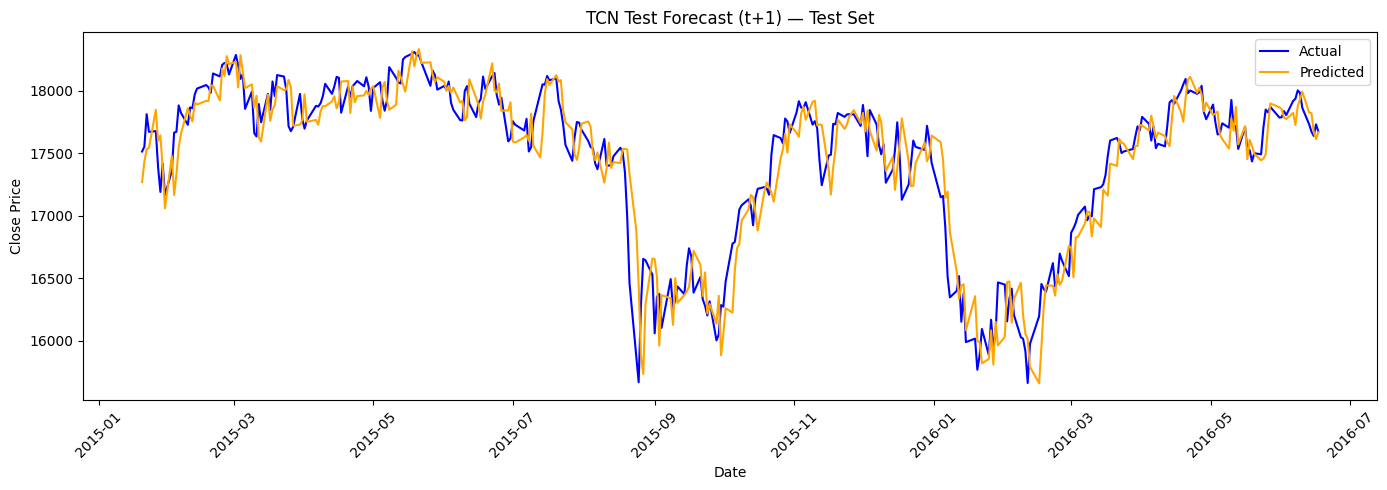


Testing TCN model for Log Returns → Close at t+3
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
TCN Test R²: 0.7584, RMSE: 316.20, MAE: 231.83


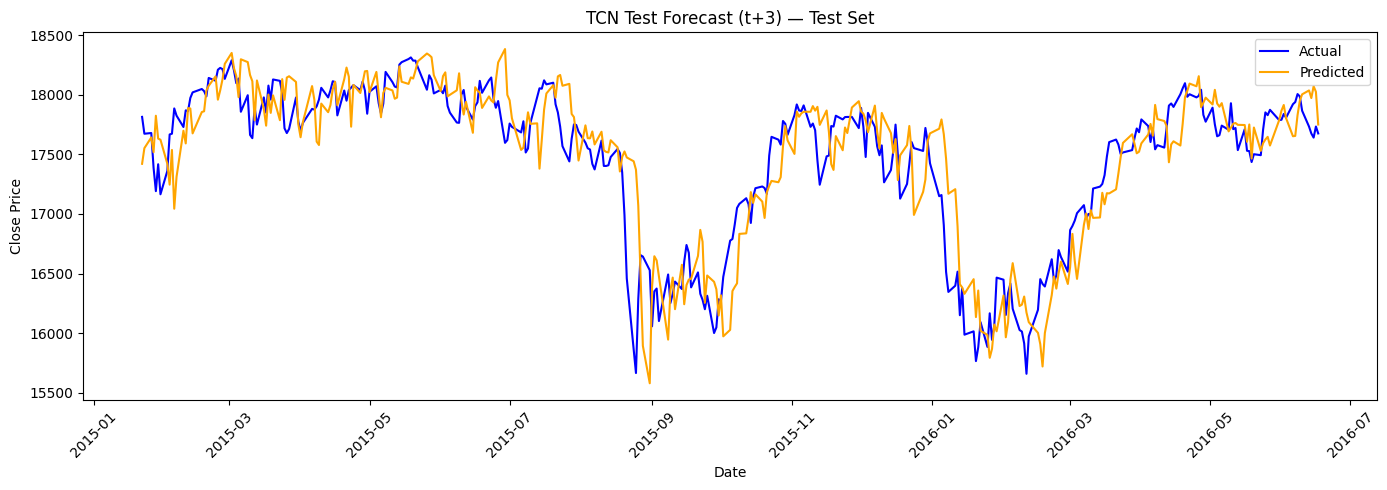


Testing TCN model for Log Returns → Close at t+7
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
TCN Test R²: 0.5483, RMSE: 434.50, MAE: 331.63


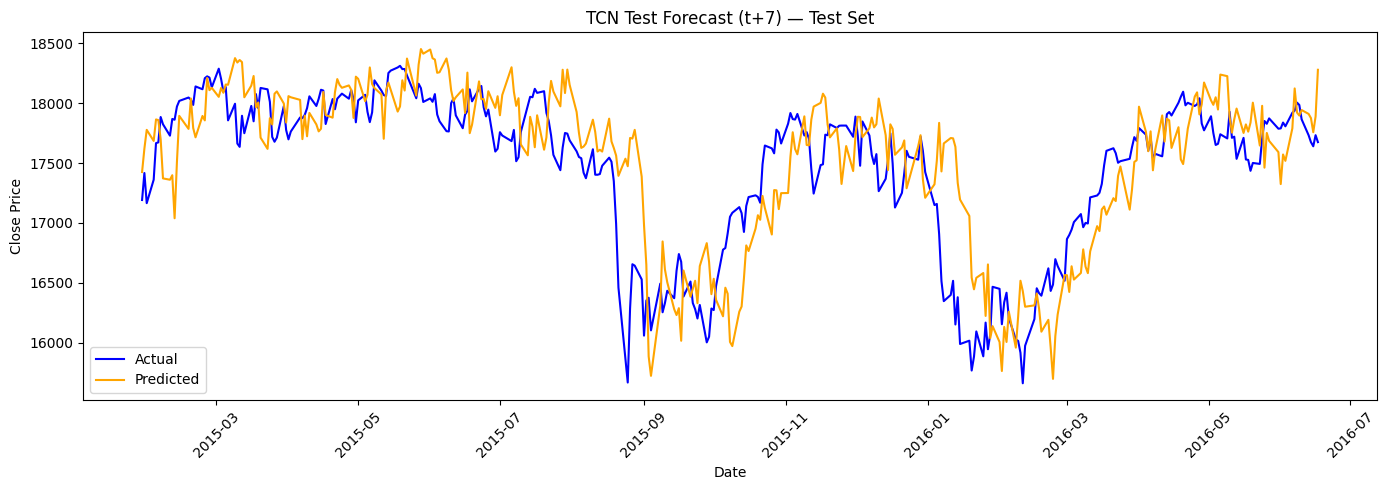

In [16]:
def test_tcn_logreturn_model(df_tcn, df_test, forecast_horizon=1, window_size=30):
    print(f"\nTesting TCN model for Log Returns → Close at t+{forecast_horizon}")

    model_name = f"tcn_logret_tplus{forecast_horizon}"
    base_path = "B:/DCU/Practicum/Proj/Models"

    # Load model and scalers
    model = load_model(f"{base_path}/{model_name}.keras", custom_objects={"TCN": TCN})
    X_scaler = joblib.load(f"{base_path}/{model_name}_scalerX.pkl")
    y_scaler = joblib.load(f"{base_path}/{model_name}_scalerY.pkl")

    # Prepare inputs and target
    df_inputs = df_tcn.iloc[:-forecast_horizon].copy()
    target_series = df_tcn['Log_Returns'].shift(-forecast_horizon).iloc[:len(df_inputs)].values

    X_scaled = X_scaler.transform(df_inputs)
    y_scaled = y_scaler.transform(target_series.reshape(-1, 1))

    # Create sequences
    X_seq, y_seq = [], []
    for i in range(window_size, len(X_scaled)):
        X_seq.append(X_scaled[i - window_size:i])
        y_seq.append(y_scaled[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Predict
    y_pred_scaled = model.predict(X_seq)
    y_pred_log = y_scaler.inverse_transform(y_pred_scaled).flatten()
    y_true_log = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()

    # Get Close_t (for log return reconstruction)
    close_t = df_tcn['Close'].iloc[window_size - 1:window_size - 1 + len(y_pred_log)].values
    y_pred_close = close_t * np.exp(y_pred_log)

    # True Close at t+h
    y_true_close = df_tcn['Close'].shift(-forecast_horizon).iloc[window_size:].values
    y_true_close = y_true_close[:len(y_pred_close)]

    assert len(y_pred_close) == len(y_true_close), "Mismatch in predicted vs actual close length"

    date_series = df_test['Date'].iloc[window_size + forecast_horizon: window_size + forecast_horizon + len(y_pred_close)]

    # Evaluation
    r2 = r2_score(y_true_close, y_pred_close)
    rmse = np.sqrt(mean_squared_error(y_true_close, y_pred_close))
    mae = mean_absolute_error(y_true_close, y_pred_close)
    print(f"TCN Test R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Save metrics
    metrics_path = os.path.join(base_path, f"{model_name}_test_metrics.txt")
    with open(metrics_path, "w") as f:
        f.write(f"Test Forecast Horizon = t+{forecast_horizon}\n")
        f.write(f"Test R²   = {r2:.4f}\n")
        f.write(f"Test RMSE = {rmse:.2f}\n")
        f.write(f"Test MAE  = {mae:.2f}\n")

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(date_series, y_true_close, label='Actual', color='blue')
    plt.plot(date_series, y_pred_close, label='Predicted', color='orange')
    plt.title(f"TCN Test Forecast (t+{forecast_horizon}) — Test Set")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/tcn_test_t_plus_{forecast_horizon}.png")
    plt.show()

    return {"r2": r2, "rmse": rmse, "mae": mae}

# Run tests
for h in [1, 3, 7]:
    clear_tf_memory()
    test_tcn_logreturn_model(df_tcn=df_tcn, df_test=df_test, forecast_horizon=h)
